# A Machine Learning Approach for Recovering Images with Missing Pixels of Fixed Pattern
## Ignasius Ian Savio Gunawan (6613230003-9)
### 2023

In this assignment, images of 256 by 256 pixels are separated into blocks of 8 by 8 pixels each. Within each block, there are 4 pixels at the center of the block that are deemed missing. The objective of this project is to fill in these missing pixels so that images with missing pixels of this pattern can be restored. In this project, 3 models are used, namely Convolution Neural Networks (CNN), Long Short-Term Memory (LSTM), and Bidirectional Long Short-Term Memory (BiLSTM). The models all use the same image samples for training, and also the same image for the testing. The performance of each model is then evaluated by calculating the Mean Squared Error (MSE) and Peak-Signal-to-Noise Ratio (PSNR), and Structural Similarity Index Measure (SSIM).

## 1. Importing necessary libraries and defining necessary variables 

In [1]:
import os.path
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import cv2 as cv


from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional, Conv2D, AveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 16px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

NUM_INP_NODES = 60
NUM_OUT_NODES = 4

BLOCK_SIZE = 8
M1 = 3
M2 = 4

SEQ_LEN_LSTM = 3
PRED_LEN_LSTM = 2

SEQ_LEN_BILSTM = 6
PRED_LEN_BILSTM = 2

## 2. Create functions to organize pixel values to training data

In [30]:
# Defining the missing pixels in a block
def is_missing_pixel(r, c):
  return (r >= M1 and c >= M1 and r <= M2 and c <= M2)

# Constructs blocks and assign each block with missing pixels in the center as inpu
# The actual values are assigned as targets
def do_parse_img_CNN(img):
    num_rows = img.shape[0]
    num_cols = img.shape[1]

    # List of input and target
    inps = []
    tgts = []
    
    for r in range(0, num_rows, BLOCK_SIZE):
        for c in range(0, num_cols, BLOCK_SIZE):
            
            # Define the 4 pixel values that the model should predict
            tgt = img[r + M1:r + M2 + 1, c + M1:c + M2 + 1]

            # Define the 64-pixel block as input
            # and make the 4 pixels in the middle 510.0 
            inp = np.copy(img[r:r + BLOCK_SIZE, c:c + BLOCK_SIZE])
            inp[M1:M2 + 1, M1:M2 + 1] = np.full(tgt.shape, 510.0)

            # flatten the target from shape of 2, 2 to just 4.
            tgt = tgt.flatten()

            # Append the derived input and target to their respective list
            inps.append(inp)
            tgts.append(tgt)

    # Convert the list to numpy arrays
    inps, tgts = np.array(inps), np.array(tgts)
            
    return inps, tgts


# Takes the pixel values of an image to sequential data for LSTM
def do_parse_img_LSTM(img):
    num_rows = img.shape[0]
    num_cols = img.shape[1]
    
    # List of input and target
    inps = []
    tgts = []

    for r in range(0, num_rows):
        for c in range(0, num_cols-SEQ_LEN_LSTM-PRED_LEN_LSTM+1):

            # For every row, there is a kind of sliding window of stride 1
            # Takes 3 pixels to the left of the 2 missing pixels as input the 2 missing pixels as the target
            inps.append(img[r][c:c+SEQ_LEN_LSTM])
            tgts.append(img[r][c+SEQ_LEN_LSTM:c+SEQ_LEN_LSTM+PRED_LEN_LSTM])

    # Convert the list to numpy arrays
    inps, tgts = np.array(inps), np.array(tgts)
            
    return inps, tgts

# Takes the pixel values of an image to sequential data for BiLSTM
def do_parse_img_BiLSTM(img):
    num_rows = img.shape[0]
    num_cols = img.shape[1]

    # List of input and target
    inps = []
    tgts = []

    for r in range(0, num_rows):
        for c in range(0, num_cols-SEQ_LEN_BILSTM-PRED_LEN_BILSTM+1):
            
            # For every row, there is a kind of sliding window of stride 1
            # Takes 3 pixels to the left and right of 2 missing pixels as input the 2 missing pixels in the middle as target
            inps.append(np.concatenate((img[r][c:c+int(SEQ_LEN_BILSTM/2)], img[r][c+int(SEQ_LEN_BILSTM/2 + PRED_LEN_BILSTM):c+int(SEQ_LEN_BILSTM + PRED_LEN_BILSTM)])))
            tgts.append(img[r][c+int(SEQ_LEN_BILSTM/2):c+int(SEQ_LEN_BILSTM/2 + PRED_LEN_BILSTM)])
    
    # Convert the list to numpy arrays           
    inps, tgts = np.array(inps), np.array(tgts)
            
    return inps, tgts

# Create a function to plot images
def imshow(img, cmap=None, vmin=0, vmax=255, frameon=False, dpi=72):
    fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi], \
                   frameon=frameon)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.show()

## 3. Iterate through the available images

In [3]:
#%% LOAD THE TRAINING DATA
img_path = "missing_pixels/"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]

num_imgs = 0

# Initialize the dataset arrays
final_trainX_CNN, final_trainY_CNN = None, None
final_trainX_LSTM, final_trainY_LSTM = None, None
final_trainX_BiLSTM, final_trainY_BiLSTM = None, None

test_img = "balloon.bmp", "bricks.bmp", "wall.bmp"
for img_fname in img_fnames:

    # skip the image(s) used for testing
    if (img_fname.lower() in test_img):
        continue

    print(img_fname)
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (256, 256), cv.INTER_LINEAR)
    img = img.astype(np.float64)
    num_imgs += 1
    print(num_imgs)

    # Incrementally expand the dataset
    trainX_CNN, trainY_CNN = do_parse_img_CNN(img)
    trainX_LSTM, trainY_LSTM = do_parse_img_LSTM(img)
    trainX_BiLSTM, trainY_BiLSTM = do_parse_img_BiLSTM(img)

    print(f"Image: {img_fname}")

    if final_trainX_CNN is None and final_trainX_LSTM is None and final_trainX_BiLSTM is None:
        final_trainX_CNN, final_trainY_CNN = trainX_CNN, trainY_CNN
        final_trainX_LSTM, final_trainY_LSTM = trainX_LSTM, trainY_LSTM
        final_trainX_BiLSTM, final_trainY_BiLSTM = trainX_BiLSTM, trainY_BiLSTM
    else:
        final_trainX_CNN = np.concatenate((final_trainX_CNN, trainX_CNN), axis=0)
        final_trainY_CNN = np.concatenate((final_trainY_CNN, trainY_CNN), axis=0)
        final_trainX_LSTM = np.concatenate((final_trainX_LSTM, trainX_LSTM), axis=0)
        final_trainY_LSTM = np.concatenate((final_trainY_LSTM, trainY_LSTM), axis=0)
        final_trainX_BiLSTM = np.concatenate((final_trainX_BiLSTM, trainX_BiLSTM), axis=0)
        final_trainY_BiLSTM = np.concatenate((final_trainY_BiLSTM, trainY_BiLSTM), axis=0)
    if (num_imgs > 1499):
        break

print("num_imgs =", num_imgs)

# For Conv2D-based model
final_trainX_CNN, final_trainY_CNN = final_trainX_CNN/255.0, final_trainY_CNN/255.0
final_trainX_CNN_reshaped = final_trainX_CNN.reshape(final_trainX_CNN.shape[0], final_trainX_CNN.shape[1], final_trainX_CNN.shape[2], 1)
final_trainY_CNN_reshaped = final_trainY_CNN.reshape(final_trainY_CNN.shape[0], final_trainY_CNN.shape[1], 1)

# For LSTM-based models
final_trainX_LSTM, final_trainY_LSTM = final_trainX_LSTM/255.0, final_trainY_LSTM/255.0
final_trainX_LSTM_reshaped = final_trainX_LSTM.reshape(final_trainX_LSTM.shape[0], final_trainX_LSTM.shape[1], 1)

# For BiLSTM-based models
final_trainX_BiLSTM, final_trainY_BiLSTM = final_trainX_BiLSTM/255.0, final_trainY_BiLSTM/255.0
final_trainX_BiLSTM_reshaped = final_trainX_BiLSTM.reshape(final_trainX_BiLSTM.shape[0], final_trainX_BiLSTM.shape[1], 1)

print("Training data shape for CNN     : ", final_trainX_CNN_reshaped.shape, final_trainY_CNN_reshaped.shape)
print("Training data shape for LSTM    : ", final_trainX_LSTM_reshaped.shape, final_trainY_LSTM.shape)
print("Training data shape for BiLSTM  : ", final_trainX_BiLSTM_reshaped.shape, final_trainY_BiLSTM.shape)

1fnoise.bmp
1
Image: 1fnoise.bmp
airplane.bmp
2
Image: airplane.bmp
baboon.bmp
3
Image: baboon.bmp
baby.bmp
4
Image: baby.bmp
barbara.bmp
5
Image: barbara.bmp
bark.bmp
6
Image: bark.bmp
barn.bmp
7
Image: barn.bmp
BEACH.BMP
8
Image: BEACH.BMP
beans.bmp
9
Image: beans.bmp
birds.bmp
10
Image: birds.bmp
branches.bmp
11
Image: branches.bmp
bridge.bmp
12
Image: bridge.bmp
buds.bmp
13
Image: buds.bmp
bushes.bmp
14
Image: bushes.bmp
cactus.bmp
15
Image: cactus.bmp
deer.bmp
16
Image: deer.bmp
desert.bmp
17
Image: desert.bmp
duck.bmp
18
Image: duck.bmp
dune2.bmp
19
Image: dune2.bmp
eagle.bmp
20
Image: eagle.bmp
FLOWERS.BMP
21
Image: FLOWERS.BMP
FOOTBALL.BMP
22
Image: FOOTBALL.BMP
fox.bmp
23
Image: fox.bmp
frog.bmp
24
Image: frog.bmp
fruits.bmp
25
Image: fruits.bmp
hawaii.bmp
26
Image: hawaii.bmp
helen.bmp
27
Image: helen.bmp
horse.bmp
28
Image: horse.bmp
HOUSE.BMP
29
Image: HOUSE.BMP
ILSVRC2012_val_00005015.JPEG
30
Image: ILSVRC2012_val_00005015.JPEG
ILSVRC2012_val_00005031.JPEG
31
Image: ILSVRC

### Save the dataset

In [31]:
'''
np.save("inputdatamissingpixel/cnndatax.npy", final_trainX_CNN_reshaped)
np.save("inputdatamissingpixel/cnndatay.npy", final_trainY_CNN_reshaped)
np.save("inputdatamissingpixel/lstmdatax.npy", final_trainX_LSTM_reshaped)
np.save("inputdatamissingpixel/lstmdatay.npy", final_trainY_LSTM)
np.save("inputdatamissingpixel/bilstmdatax.npy", final_trainX_BiLSTM_reshaped)
np.save("inputdatamissingpixel/bilstmdatay.npy", final_trainY_BiLSTM)
'''

'\nnp.save("inputdatamissingpixel/cnndatax.npy", final_trainX_CNN_reshaped)\nnp.save("inputdatamissingpixel/cnndatay.npy", final_trainY_CNN_reshaped)\nnp.save("inputdatamissingpixel/lstmdatax.npy", final_trainX_LSTM_reshaped)\nnp.save("inputdatamissingpixel/lstmdatay.npy", final_trainY_LSTM)\nnp.save("inputdatamissingpixel/bilstmdatax.npy", final_trainX_BiLSTM_reshaped)\nnp.save("inputdatamissingpixel/bilstmdatay.npy", final_trainY_BiLSTM)\n'

### Load the saved dataset

In [11]:
# Depending on the version of the libraries, the reshaped version of the CNN dataset might be unnecessary
final_trainX_CNN_reshaped = np.load("inputdatamissingpixel/cnndatax.npy")
final_trainX_CNN = final_trainX_CNN_reshaped.reshape(final_trainX_CNN_reshaped.shape[0], final_trainX_CNN_reshaped.shape[1], final_trainX_CNN_reshaped.shape[2])
final_trainY_CNN_reshaped = np.load("inputdatamissingpixel/cnndatay.npy")
final_trainY_CNN = final_trainY_CNN_reshaped.reshape(final_trainY_CNN_reshaped.shape[0], final_trainY_CNN_reshaped.shape[1])

final_trainX_LSTM_reshaped = np.load("inputdatamissingpixel/lstmdatax.npy")
final_trainY_LSTM = np.load("inputdatamissingpixel/lstmdatay.npy")
final_trainX_BiLSTM_reshaped = np.load("inputdatamissingpixel/bilstmdatax.npy")
final_trainY_BiLSTM = np.load("inputdatamissingpixel/bilstmdatay.npy")

## 4. Build the models

In [12]:
cnn = Sequential()
cnn.add(Conv2D(128, kernel_size=(4,4), padding="same", activation='relu',input_shape=(BLOCK_SIZE, BLOCK_SIZE, 1)))
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(Conv2D(256, kernel_size=(4,4), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(Conv2D(512, kernel_size=(4,4), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(NUM_OUT_NODES*16))
cnn.add(Dense(NUM_OUT_NODES))
cnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         2176      
                                                                 
 average_pooling2d_3 (Averag  (None, 4, 4, 128)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)         524544    
                                                                 
 average_pooling2d_4 (Averag  (None, 2, 2, 256)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 512)         2097664   
                                                                 
 average_pooling2d_5 (Averag  (None, 1, 1, 512)       

In [13]:
# Training for CNN
cnn.fit(final_trainX_CNN, final_trainY_CNN, epochs=500, batch_size=1024,
  validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)])

Epoch 1/500
1350/1350 [==============================] - 39s 24ms/step - loss: 0.0035 - accuracy: 0.3861 - val_loss: 0.0013 - val_accuracy: 0.4767
Epoch 2/500
1350/1350 [==============================] - 33s 24ms/step - loss: 0.0018 - accuracy: 0.4375 - val_loss: 0.0011 - val_accuracy: 0.5942
Epoch 3/500
1350/1350 [==============================] - 33s 24ms/step - loss: 0.0016 - accuracy: 0.4538 - val_loss: 0.0012 - val_accuracy: 0.4547
Epoch 4/500
1350/1350 [==============================] - 33s 24ms/step - loss: 0.0014 - accuracy: 0.4685 - val_loss: 9.3544e-04 - val_accuracy: 0.4092
Epoch 5/500
1350/1350 [==============================] - 33s 25ms/step - loss: 0.0014 - accuracy: 0.4776 - val_loss: 0.0010 - val_accuracy: 0.5515
Epoch 6/500
1350/1350 [==============================] - 33s 25ms/step - loss: 0.0013 - accuracy: 0.4845 - val_loss: 8.2205e-04 - val_accuracy: 0.6290
Epoch 7/500
1350/1350 [==============================] - 34s 25ms/step - loss: 0.0013 - accuracy: 0.4873 - val

In [15]:
#cnn.save("finalcnn") # Save the desired CNN model
#cnn = load_model("finalcnn") # Load existing CNN model

INFO:tensorflow:Assets written to: finalcnn\assets


INFO:tensorflow:Assets written to: finalcnn\assets


In [24]:
lstm = Sequential()
lstm.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN_LSTM, 1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(SEQ_LEN_LSTM, 1)))
lstm.add(Dropout(0.2))
lstm.add(Dense(final_trainY_LSTM.shape[1]))
lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 128)            66560     
                                                                 
 dropout_6 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 116,098
Trainable params: 116,098
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.fit(final_trainX_LSTM_reshaped, final_trainY_LSTM, epochs=50, batch_size=1024,
  validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/50
85050/85050 [==============================] - 437s 5ms/step - loss: 0.0061 - accuracy: 0.5471 - val_loss: 0.0051 - val_accuracy: 0.5585
Epoch 2/50
85050/85050 [==============================] - 430s 5ms/step - loss: 0.0059 - accuracy: 0.5491 - val_loss: 0.0051 - val_accuracy: 0.5622
Epoch 3/50
85050/85050 [==============================] - 428s 5ms/step - loss: 0.0059 - accuracy: 0.5488 - val_loss: 0.0050 - val_accuracy: 0.5597
Epoch 4/50
85050/85050 [==============================] - 427s 5ms/step - loss: 0.0059 - accuracy: 0.5486 - val_loss: 0.0051 - val_accuracy: 0.5448
Epoch 5/50
85050/85050 [==============================] - 431s 5ms/step - loss: 0.0058 - accuracy: 0.5476 - val_loss: 0.0051 - val_accuracy: 0.5452
Epoch 6/50
85050/85050 [==============================] - 429s 5ms/step - loss: 0.0058 - accuracy: 0.5473 - val_loss: 0.0050 - val_accuracy: 0.5667
Epoch 7/50
85050/85050 [==============================] - 430s 5ms/step - loss: 0.0058 - accuracy: 0.5474 - val_

In [24]:
#lstm.save("finallstm")
#lstm = load_model("finallstm")

In [11]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=(SEQ_LEN_BILSTM, 1)))
bilstm.add(Dropout(0.2))
bilstm.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=False), input_shape=(SEQ_LEN_BILSTM, 1)))
bilstm.add(Dropout(0.2))
bilstm.add(Dense(final_trainY_BiLSTM.shape[1]))
bilstm.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 6, 128)           33792     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 6, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 132,866
Trainable params: 132,866
Non-tr

In [12]:
bilstm.fit(final_trainX_BiLSTM_reshaped, final_trainY_BiLSTM, epochs=50, batch_size=1024,
  validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/50
84038/84038 [==============================] - 719s 8ms/step - loss: 0.0028 - accuracy: 0.6595 - val_loss: 0.0020 - val_accuracy: 0.6876
Epoch 2/50
84038/84038 [==============================] - 706s 8ms/step - loss: 0.0026 - accuracy: 0.6764 - val_loss: 0.0020 - val_accuracy: 0.8002
Epoch 3/50
84038/84038 [==============================] - 710s 8ms/step - loss: 0.0026 - accuracy: 0.6801 - val_loss: 0.0020 - val_accuracy: 0.8036
Epoch 4/50
84038/84038 [==============================] - 709s 8ms/step - loss: 0.0026 - accuracy: 0.6821 - val_loss: 0.0020 - val_accuracy: 0.6565
Epoch 5/50
84038/84038 [==============================] - 708s 8ms/step - loss: 0.0026 - accuracy: 0.6833 - val_loss: 0.0020 - val_accuracy: 0.7414
Epoch 6/50
84038/84038 [==============================] - 712s 8ms/step - loss: 0.0025 - accuracy: 0.6841 - val_loss: 0.0020 - val_accuracy: 0.7089
Epoch 7/50
84038/84038 [==============================] - 712s 8ms/step - loss: 0.0025 - accuracy: 0.6847 - val_

In [25]:
#bilstm.save("finalbilstm")
#bilstm = load_model("finalbilstm")

## 5. Model Prediction (Testing and Evaluation)

For balloon.bmp


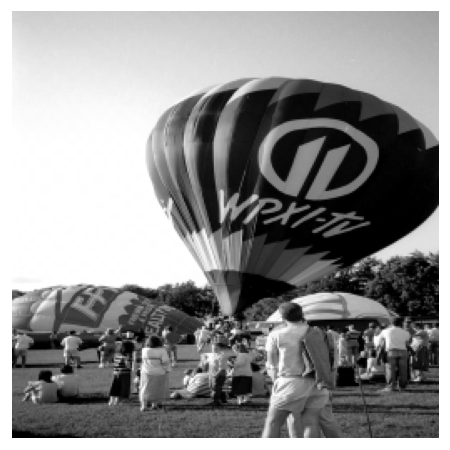

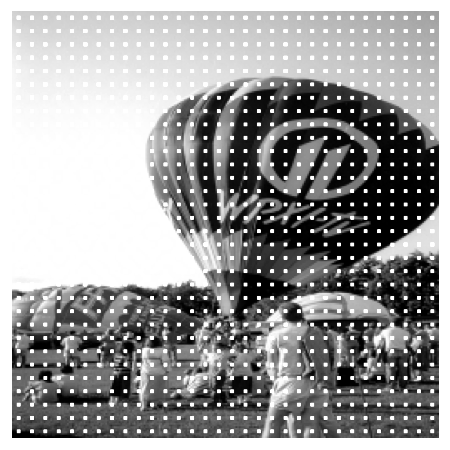

For bricks.bmp


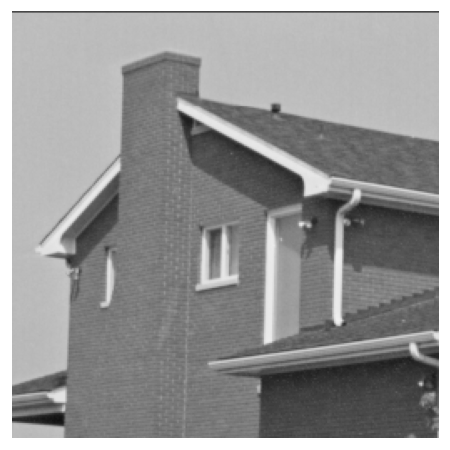

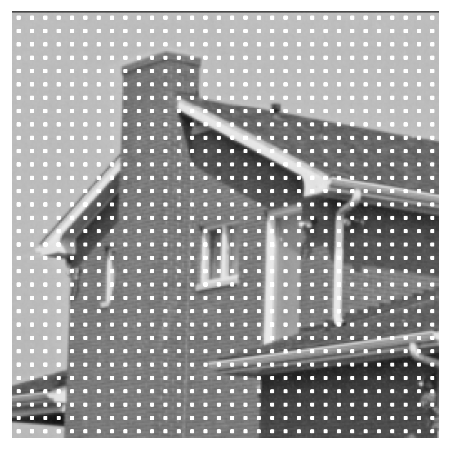

For wall.bmp


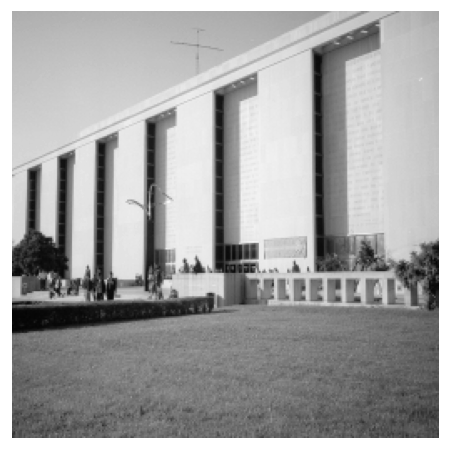

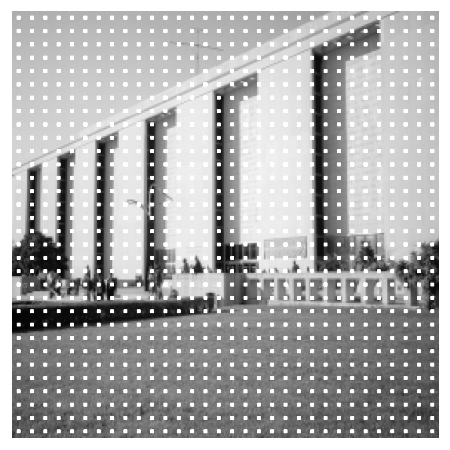

In [22]:
# Load the three test images

img_path = "missing_pixels/"

img1 = cv.imread(join(img_path, "balloon.bmp"), cv.IMREAD_GRAYSCALE)
img1 = cv.resize(img1, (256, 256), cv.INTER_CUBIC)
img1 = img1.astype(np.float64)

img2 = cv.imread(join(img_path, "bricks.bmp"), cv.IMREAD_GRAYSCALE)
img2 = cv.resize(img2, (256, 256), cv.INTER_CUBIC)
img2 = img2.astype(np.float64)

img3 = cv.imread(join(img_path, "wall.bmp"), cv.IMREAD_GRAYSCALE)
img3 = cv.resize(img3, (256, 256), cv.INTER_CUBIC)
img3 = img3.astype(np.float64)

# Initialize the incomplete version of the original images
num_rows = img1.shape[0]
num_cols = img1.shape[1]
rec_img1 = np.zeros((num_rows, num_cols))
rec_img2 = np.zeros((num_rows, num_cols))
rec_img3 = np.zeros((num_rows, num_cols))

# Assign the missing pixel values as 510 (twice the range of values)
blk_pos = 0
for r0 in range(0, num_rows, BLOCK_SIZE):
    for c0 in range(0, num_cols, BLOCK_SIZE):
        # fill in the outer and context pixels
        for r in range(BLOCK_SIZE):
            for c in range(BLOCK_SIZE):
                if not is_missing_pixel(r, c):
                    rec_img1[r0 + r, c0 + c] = img1[r0 + r, c0 + c]
                    rec_img2[r0 + r, c0 + c] = img2[r0 + r, c0 + c]
                    rec_img3[r0 + r, c0 + c] = img3[r0 + r, c0 + c]
                else:
                    rec_img1[r0 + r, c0 + c] = 510.0
                    rec_img2[r0 + r, c0 + c] = 510.0
                    rec_img3[r0 + r, c0 + c] = 510.0

# Show the images
print("For balloon.bmp")
imshow(img1, "gray", dpi=72)
imshow(rec_img1, "gray", dpi=72)

print("For bricks.bmp")
imshow(img2, "gray", dpi=72)
imshow(rec_img2, "gray", dpi=72)

print("For wall.bmp")
imshow(img3, "gray", dpi=72)
imshow(rec_img3, "gray", dpi=72)


In [20]:
# Structural Similarity Index Measure
def calculate_ssim(test, pred):

    # Two constants to stabilize the division
    k1 = 0.01
    k2 = 0.03

    # The range of the pixel values in an image
    L = np.max(test)

    # Normalization constants
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Derive the average value in each image
    mean_test = np.mean(test)
    mean_pred = np.mean(pred)
    
    # Derive the variance value in each image
    var_test = np.var(test)
    var_pred = np.var(pred)

    # Calculate the covariance between the two images
    covar = np.cov(test.flatten(), pred.flatten())[0, 1]

    numerator = (2 * mean_test * mean_pred + c1) * (2 * covar + c2)
    denominator = (mean_test ** 2 + mean_pred ** 2 + c1) * (var_test + var_pred + c2)

    ssim_score = numerator / denominator
    return ssim_score

# The function to perform evaluation and calculate metrics
def evaluate(testimg, predimg):
    err = predimg - testimg
    mse = (err**2).mean()
    rmse = np.sqrt(mse)
    psnr = 20 * np.log10(255.0) - 10 * np.log10(mse)
    ssim = calculate_ssim(testimg, predimg)
    print("MSE =", "{:.2f}".format(mse))
    print("RMSE =", "{:.2f}".format(rmse))
    print("PSNR =", "{:.2f}".format(psnr))
    print("SSIM =", "{:.2f}".format(ssim))
    return mse, rmse, psnr, ssim

# Run the CNN model on a test image and compute evaluation metrics
def CNNpred(cnnmodel, testimg):
    testX, testY = do_parse_img_CNN(testimg)
    testX, testY = testX/255.0, testY/255.0
    for idx in range(len(testX)):
        testX[idx, :] = testX[idx]
        testY[idx] = testY[idx]
    # predict the missing pixels
    predY = cnnmodel.predict(testX)

    num_rows = testimg.shape[0]
    num_cols = testimg.shape[1]
    rec_img = np.zeros((num_rows, num_cols))
    
    blk_pos = 0
    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            # fill in the outer and context pixels
            for r in range(BLOCK_SIZE):
                for c in range(BLOCK_SIZE):
                    assert(r0 + r < num_rows)
                    assert(c0 + c < num_cols)
                    if not is_missing_pixel(r, c):
                        rec_img[r0 + r, c0 + c] = testimg[r0 + r, c0 + c]
            out = predY[blk_pos]
            blk_pos += 1
            
            # fill in the missing pixels
            pos = 0
            for r in range(BLOCK_SIZE):
                for c in range(BLOCK_SIZE):
                    assert(r0 + r < num_rows)
                    assert(c0 + c < num_cols)
                    if is_missing_pixel(r, c):
                        rec_img[r0 + r, c0 + c] = 255*out[pos]
                        pos += 1

    
    print("Original Test Image")
    imshow(testimg, "gray", dpi=72)
    print("Predicted Image")
    imshow(rec_img, "gray", dpi=72)
    eval = evaluate(testimg, rec_img)
    
    return rec_img, eval

# Run the LSTM model on a test image and compute evaluation metrics
def LSTMpred(lstmmodel, testimg):

    num_rows = testimg.shape[0]
    num_cols = testimg.shape[1]
    rec_img = np.zeros((num_rows, num_cols))

    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            # fill in the outer and context pixels
            for r in range(BLOCK_SIZE):
                for c in range(BLOCK_SIZE):
                    if not is_missing_pixel(r, c):
                        rec_img[r0 + r, c0 + c] = testimg[r0 + r, c0 + c]
                    else:
                        rec_img[r0 + r, c0 + c] = 510.0

    # Normalize the reconstructed image
    rec_img = rec_img/255.0
    rec_img = rec_img.flatten()
    
    for i in range(len(rec_img)):

        # Determine whether a pixel is considered missing
        if rec_img[i] == 510.0/255.0 and rec_img[i+1] == 510.0/255.0:

            # Depending on how the dataset is organized, the model's method also differs
            if PRED_LEN_LSTM == 2:
                pred = lstmmodel.predict(rec_img[i-SEQ_LEN_LSTM:i].reshape(1,SEQ_LEN_LSTM,1))
                rec_img[i], rec_img[i+1] = pred[0][0], pred[0][1]
            if PRED_LEN_LSTM == 1:
                pred1 = lstmmodel.predict(rec_img[i-SEQ_LEN_LSTM:i].reshape(1,SEQ_LEN_LSTM,1))
                rec_img[i] = pred1[0]
                pred2 = lstmmodel.predict(rec_img[i-SEQ_LEN_LSTM+1:i+1].reshape(1,SEQ_LEN_LSTM,1))
                rec_img[i+1] = pred2[0]
    rec_img = rec_img.reshape(testimg.shape)*255.0
    
    print("Original Test Image")
    imshow(testimg, "gray", dpi=72)
    print("Predicted Image")
    imshow(rec_img, "gray", dpi=72)
    eval = evaluate(testimg, rec_img)
    
    return rec_img, eval

# Run the BiLSTM model on a test image and compute evaluation metrics
def BiLSTMpred(bilstmmodel, testimg):

    num_rows = testimg.shape[0]
    num_cols = testimg.shape[1]
    rec_img = np.zeros((num_rows, num_cols))

    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            # fill in the outer and context pixels
            for r in range(BLOCK_SIZE):
                for c in range(BLOCK_SIZE):
                    if not is_missing_pixel(r, c):
                        rec_img[r0 + r, c0 + c] = testimg[r0 + r, c0 + c]
                    else:
                        rec_img[r0 + r, c0 + c] = 510.0
        
    # Normalize the reconstructed image
    rec_img = rec_img/255.0
    rec_img = rec_img.flatten()
    
    for i in range(len(rec_img)):
        
        # Determine whether a pixel is considered missing
        if rec_img[i] == 510.0/255.0 and rec_img[i+1] == 510.0/255.0:
            left = rec_img[i-int(SEQ_LEN_BILSTM/2):i]
            right = rec_img[i+int(PRED_LEN_BILSTM):i+int(SEQ_LEN_BILSTM/2 + PRED_LEN_BILSTM)]
            feed = np.concatenate((left,right))
            pred = bilstmmodel.predict(feed.reshape(1,SEQ_LEN_BILSTM,1))
            rec_img[i], rec_img[i+1] = pred[0][0], pred[0][1]

    rec_img = rec_img.reshape(testimg.shape)*255.0
    
    print("Original Test Image")
    imshow(testimg, "gray", dpi=72)
    print("Predicted Image")
    imshow(rec_img, "gray", dpi=72)
    eval = evaluate(testimg, rec_img)
    
    return rec_img, eval

32/32 [==============================] - 1s 2ms/step
Original Test Image


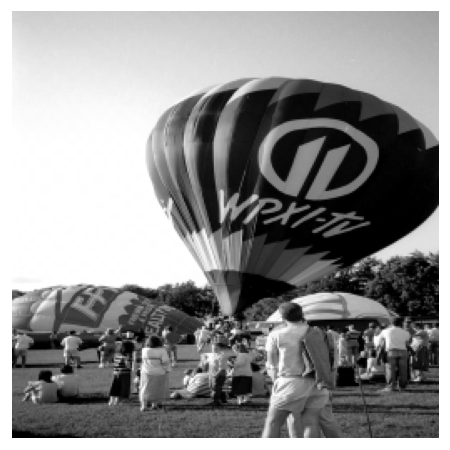

Predicted Image


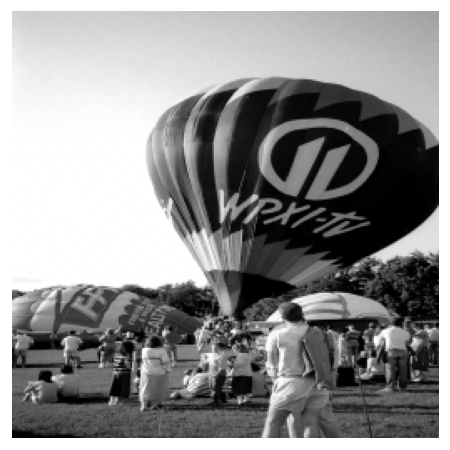

MSE = 8.20
RMSE = 2.86
PSNR = 38.99
SSIM = 1.00
32/32 [==============================] - 0s 2ms/step
Original Test Image


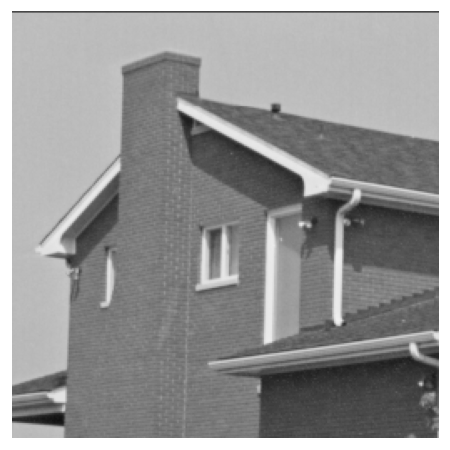

Predicted Image


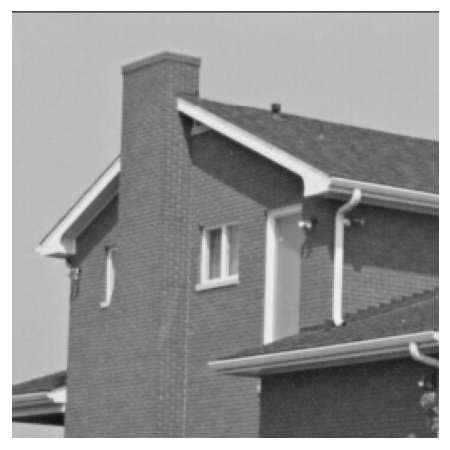

MSE = 1.00
RMSE = 1.00
PSNR = 48.14
SSIM = 1.00
32/32 [==============================] - 0s 2ms/step
Original Test Image


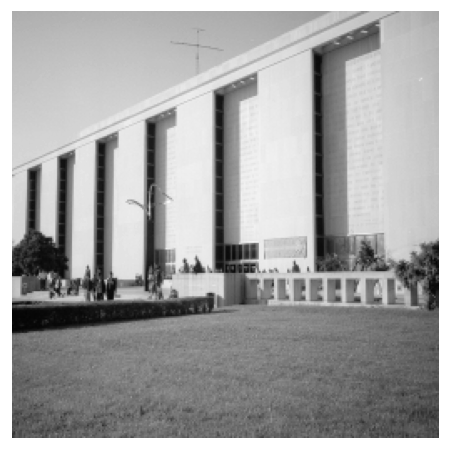

Predicted Image


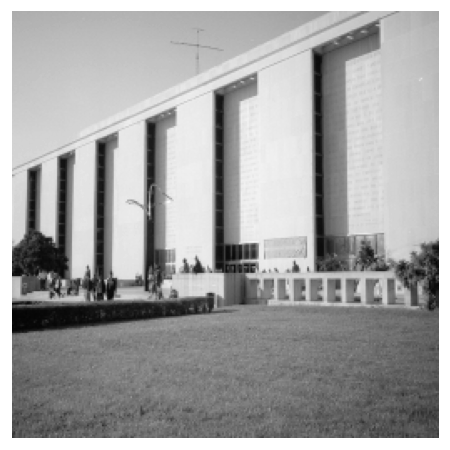

MSE = 4.17
RMSE = 2.04
PSNR = 41.93
SSIM = 1.00


In [23]:
cnn1 = CNNpred(cnn, img1)
cnn2 = CNNpred(cnn, img2)
cnn3 = CNNpred(cnn, img3)

1/1 [==============================] - 0s 16ms/step
Original Test Image


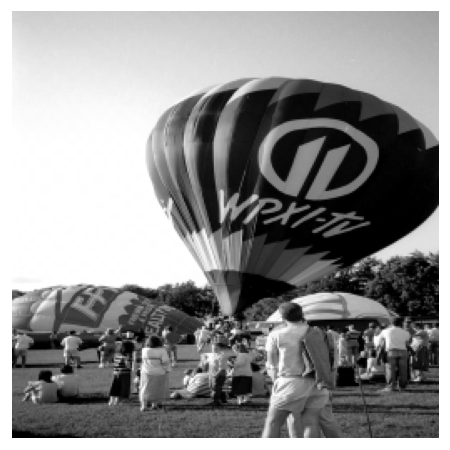

Predicted Image


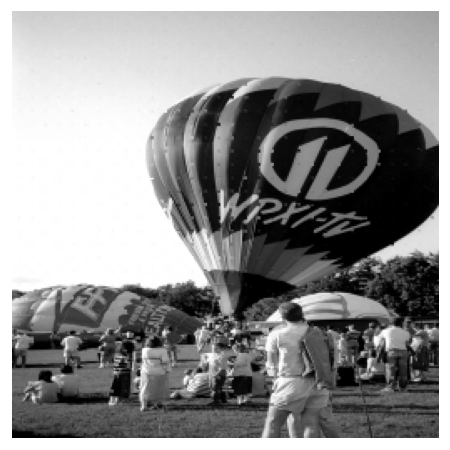

MSE = 41.08
RMSE = 6.41
PSNR = 31.99
SSIM = 1.00
1/1 [==============================] - 0s 16ms/step
Original Test Image


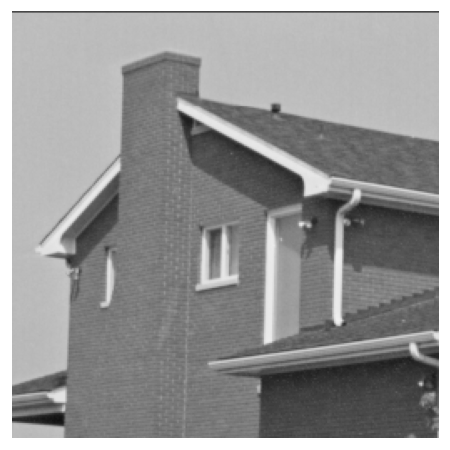

Predicted Image


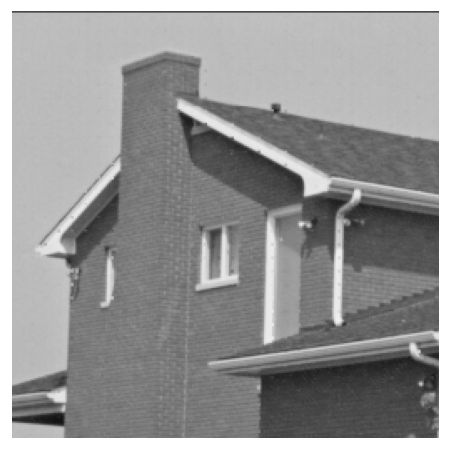

MSE = 5.16
RMSE = 2.27
PSNR = 41.00
SSIM = 1.00
1/1 [==============================] - 0s 20ms/step
Original Test Image


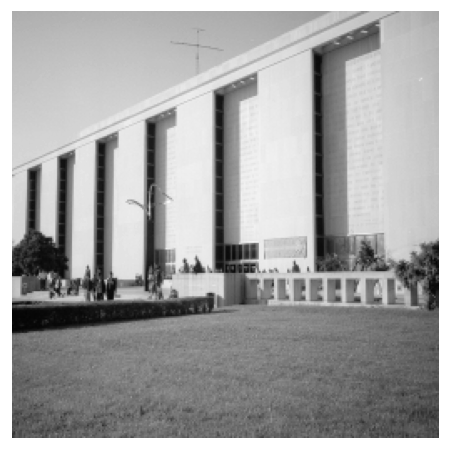

Predicted Image


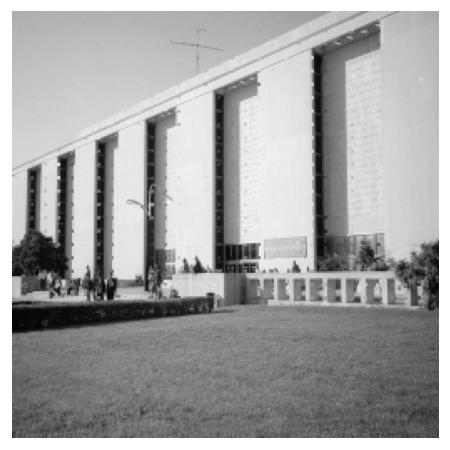

MSE = 30.86
RMSE = 5.56
PSNR = 33.24
SSIM = 1.00


In [26]:
lstm1 = LSTMpred(lstm, img1)
lstm2 = LSTMpred(lstm, img2)
lstm3 = LSTMpred(lstm, img3)

1/1 [==============================] - 0s 19ms/step
Original Test Image


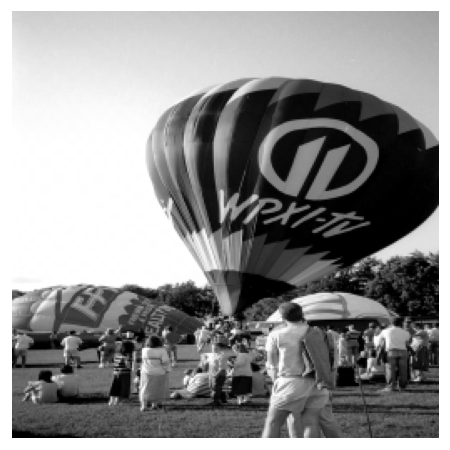

Predicted Image


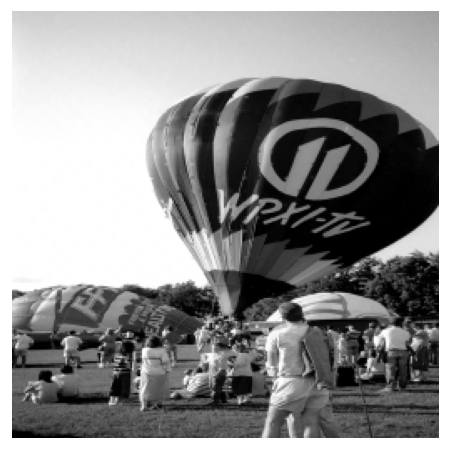

MSE = 17.90
RMSE = 4.23
PSNR = 35.60
SSIM = 1.00
1/1 [==============================] - 0s 18ms/step
Original Test Image


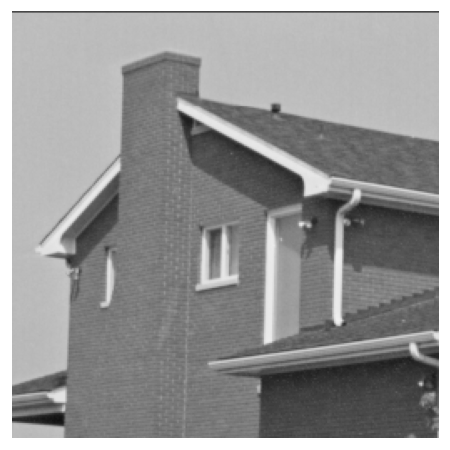

Predicted Image


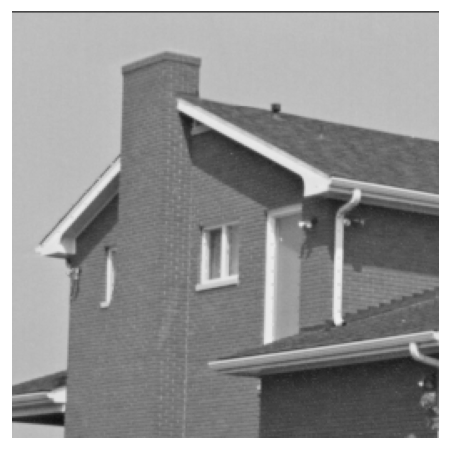

MSE = 1.57
RMSE = 1.25
PSNR = 46.18
SSIM = 1.00
1/1 [==============================] - 0s 18ms/step
Original Test Image


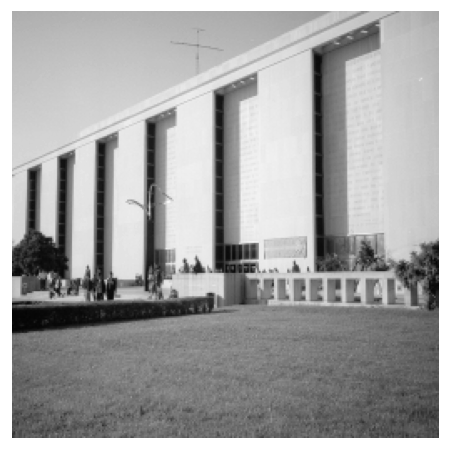

Predicted Image


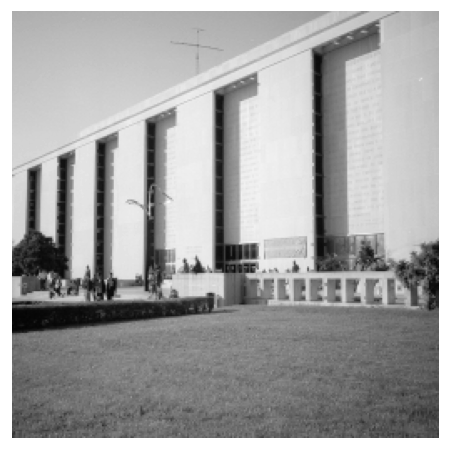

MSE = 12.52
RMSE = 3.54
PSNR = 37.15
SSIM = 1.00


In [27]:
bilstm1 = BiLSTMpred(bilstm, img1)
bilstm2 = BiLSTMpred(bilstm, img2)
bilstm3 = BiLSTMpred(bilstm, img3)

In [28]:
# Three test images are balloon.bmp, bricks.bmp, and wall.bmp
cv.imwrite("evaluation/testOri1.png", img1)
cv.imwrite("evaluation/testOri2.png", img2)
cv.imwrite("evaluation/testOri3.png", img3)

# Missing pixel versions of the original test images
cv.imwrite("evaluation/testMiss1.png", rec_img1)
cv.imwrite("evaluation/testMiss2.png", rec_img2)
cv.imwrite("evaluation/testMiss3.png", rec_img3)

# Predicted images for each model
cv.imwrite("evaluation/cnnTest1.png", cnn1[0])
cv.imwrite("evaluation/cnnTest2.png", cnn2[0])
cv.imwrite("evaluation/cnnTest3.png", cnn3[0])

cv.imwrite("evaluation/lstmTest1.png", lstm1[0])
cv.imwrite("evaluation/lstmTest2.png", lstm2[0])
cv.imwrite("evaluation/lstmTest3.png", lstm3[0])

cv.imwrite("evaluation/bilstmTest1.png", bilstm1[0])
cv.imwrite("evaluation/bilstmTest2.png", bilstm2[0])
cv.imwrite("evaluation/bilstmTest3.png", bilstm3[0])

True

In [29]:
print("EVALUATION (MSE, RMSE, PSNR, SSIM)")
print("CNN")
print(cnn1[1])
print(cnn2[1])
print(cnn3[1])
print("LSTM")
print(lstm1[1])
print(lstm2[1])
print(lstm3[1])
print("BiLSTM")
print(bilstm1[1])
print(bilstm2[1])
print(bilstm3[1])

EVALUATION (MSE, RMSE, PSNR, SSIM)
CNN
(8.200133214899084, 2.8635874728911435, 38.99259453115213, 0.9994895584933247)
(0.997185008070987, 0.9985915121164344, 48.14304620279041, 0.9997833776714606)
(4.166970154712123, 2.041315790051143, 41.932599709674484, 0.9994539382602223)
LSTM
(41.079924005938615, 6.409362215223806, 31.994507293465656, 0.9973756743125041)
(5.162107260401976, 2.2720271258068148, 41.002533366157465, 0.9988124926123517)
(30.860363330450756, 5.555210466800584, 33.236793260014096, 0.9958398432711698)
BiLSTM
(17.8972008694937, 4.23050834646307, 35.602952484350524, 0.9988671256448894)
(1.565836982657962, 1.2513340811541744, 46.183338146512824, 0.9996507942607263)
(12.523074145907012, 3.5387955784287697, 37.153694089325356, 0.9983267632701763)
